In [1]:
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
path_train_data = "MNIST/mnist_training_data.mat"
path_train_label = "MNIST/mnist_training_label.mat"
path_test_data = "MNIST/mnist_test_data.mat"
path_test_label = "MNIST/mnist_test_label.mat"

In [4]:
train_data_mat = loadmat(path_train_data)
train_data = train_data_mat['training_data']

train_label_mat = loadmat(path_train_label)
train_label = train_label_mat['training_label']

test_data_mat = loadmat(path_test_data)
test_data = test_data_mat['test_data']

test_label_mat = loadmat(path_test_label)
test_label = test_label_mat['test_label']

In [5]:
X_train = train_data.reshape((train_data.shape[0], 28, 28, 1))
X_test = test_data.reshape((test_data.shape[0], 28, 28, 1))
X_train.shape, X_test.shape

((50000, 28, 28, 1), (10000, 28, 28, 1))

In [6]:
noise_factor = 0.3
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape) 
X_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape) 

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)
X_train_noisy.shape, X_test_noisy.shape

(TensorShape([50000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

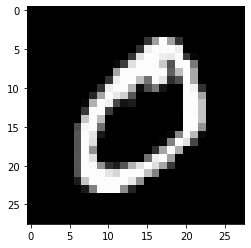

In [7]:
plt.imshow(X_train[0], cmap='gray')

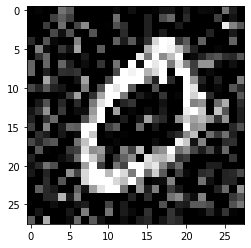

In [8]:
plt.imshow(X_train_noisy[0], cmap='gray')

In [9]:
lam = tf.keras.regularizers.l1(l=0.00001)
input_img = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=2, padding='same', kernel_regularizer=lam)(input_img)
encoder_output = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)

x = tf.keras.layers.Conv2DTranspose(8, kernel_size=3, activation='relu', strides=2, padding='same', kernel_regularizer=lam)(encoder_output)
x = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='relu', strides=2, padding='same', kernel_regularizer=lam)(x)
decoder_output = tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', kernel_regularizer=lam)(x)
autoencoder = tf.keras.Model(input_img, decoder_output)

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
___________________________________________________________

In [11]:
autoencoder.compile(optimizer='adam', loss='mse')

In [12]:
history = autoencoder.fit(X_train_noisy, X_train, epochs=25, batch_size=128, validation_split=0.2)

Epoch 1/25
313/313 [==============================] - 9s 12ms/step - loss: 0.1277 - val_loss: 0.0171
Epoch 2/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 3/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 4/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0098 - val_loss: 0.0107
Epoch 5/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0093 - val_loss: 0.0102
Epoch 6/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 7/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 8/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 9/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0083 - val_loss: 0.0093
Epoch 10/25
313/313 [==============================] - 3s 9ms/step - loss: 0.0082 - val_loss: 0.009

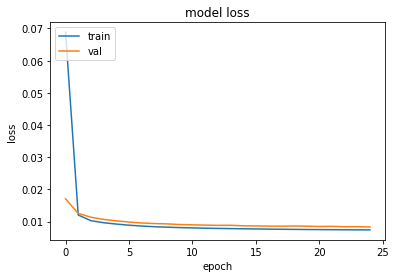

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
X_test_decoded = autoencoder(X_test_noisy)

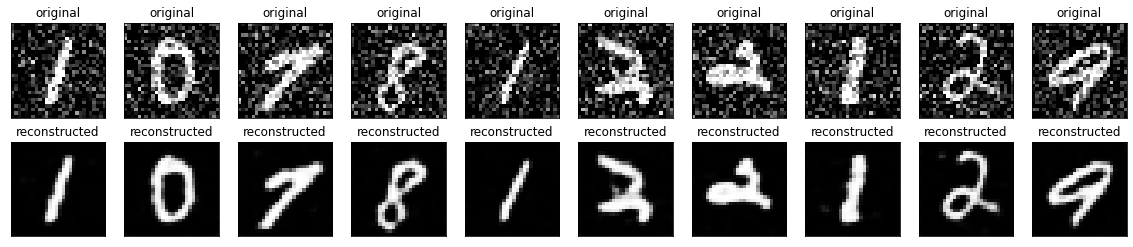

In [15]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ii = np.random.randint(0, 10000);
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test_noisy[ii]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(X_test_decoded[ii]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

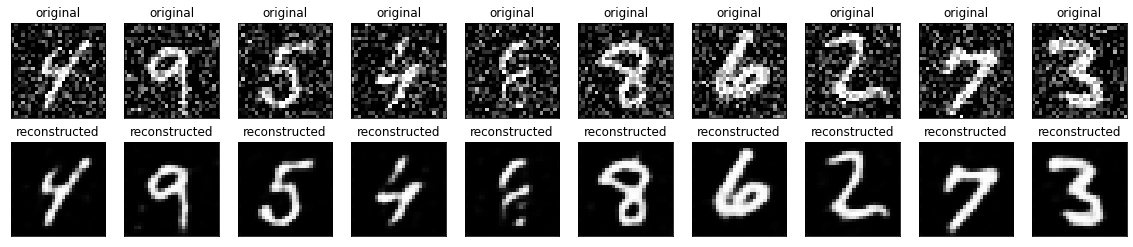

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ii = np.random.randint(0, 10000);
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test_noisy[ii]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(X_test_decoded[ii]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()